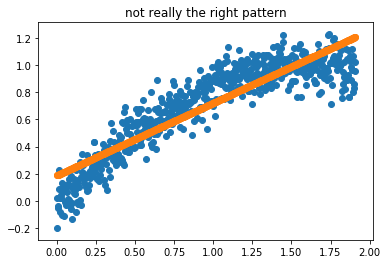

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression

n = 600
s = 0 

xs = np.arange(s, s + n)/100/np.pi
ys = np.sin(xs) + np.random.normal(0, 0.1, n)

pred_ys = LinearRegression().fit(xs.reshape(-1, 1), ys).predict(xs.reshape(-1, 1))
plt.scatter(xs, ys)
plt.scatter(xs, pred_ys)
plt.title("not really the right pattern");

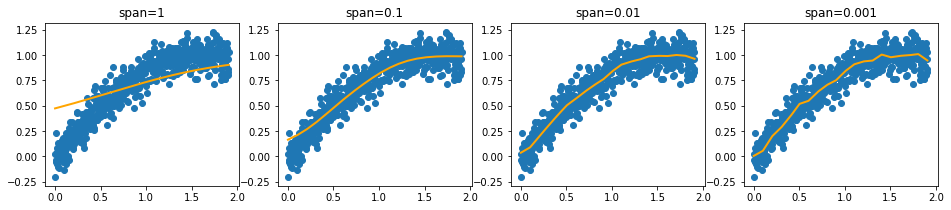

In [2]:
from sklego.preprocessing import IntervalEncoder

plt.figure(figsize = (16, 3))

for idx, sigma in enumerate([1, 0.1, 0.01, 0.001]):
    plt.subplot(140 + idx + 1)
    fs = IntervalEncoder(n_chunks=20, span=sigma, method='normal').fit(xs.reshape(-1, 1), ys)
    plt.scatter(xs, ys);
    plt.plot(xs, fs.transform(xs.reshape(-1, 1)), color='orange', linewidth=2.0)
    plt.title(f"span={sigma}");

In [4]:
import numpy as np
import pandas as pd
from patsy import dmatrix, build_design_matrices, PatsyError
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import FLOAT_DTYPES, check_random_state, check_is_fitted

In [85]:
def _mk_average(xs, ys, intervals, method="average", span=1, **kwargs):
    """
    Creates smoothed averages of `ys` at the intervals given by `intervals`.
    :param xs: all the datapoints of a feature (represents the x-axis)
    :param ys: all the datapoints what we'd like to predict (represents the y-axis)
    :param intervals: the intervals at which we'd like to get a good average value
    :param method: the method that is used for smoothing, can be either `average` or `normal`.
    :param span: if the method is `average` then this is the span around the interval
    that is used to determine the average `y`-value, if the method is `normal` the span
    becomes the value of sigma that is used for weighted averaging
    :return:
        An array as long as `intervals` that represents the average `y`-values at those intervals.
    """
    results = np.zeros(intervals.shape)
    for idx, interval in enumerate(intervals):
        if method == "average":
            distances = 1 / (0.01 + np.abs(xs - interval))
            predicate = (xs < (interval + span)) | (xs < (interval - span))
        elif method == "normal":
            distances = np.exp(-((xs - interval) ** 2) / span)
            predicate = xs == xs
        else:
            raise ValueError("method needs to be either `average` or `normal`")
        subset = ys[predicate]
        dist_subset = distances[predicate]
        results[idx] = np.average(subset, weights=dist_subset)
    return results

Let's make sure that these functions work allright.

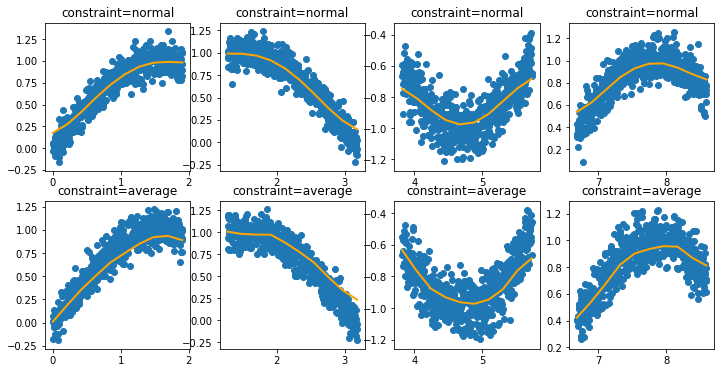

In [86]:
def generate_dataset(start, n=600):
    xs = np.arange(start, start + n)/100/np.pi
    y = np.sin(xs) + np.random.normal(0, 0.1, n)
    return xs.reshape(-1, 1), y

i = 0
plt.figure(figsize=(12, 6))
for method in ['normal', 'average']:
    for data_init in [0, 400, 1200, 2100]:
        i += 1
        xs, ys = generate_dataset(start=data_init)
        xs = xs.reshape(-1)
        plt.subplot(240 + i)
        plt.scatter(xs, ys) 
        intervals = np.quantile(xs, np.linspace(0, 1, 10))
        plt.plot(intervals, _mk_average(xs, ys, intervals=intervals, method=method, span=0.1), color="orange", linewidth=2.0)
        plt.title(f"constraint={method}");

In [91]:
def _mk_monotonic_average(xs, ys, intervals, method="increasing", **kwargs):
    """
    Creates smoothed averages of `ys` at the intervals given by `intervals`.
    :param xs: all the datapoints of a feature (represents the x-axis)
    :param ys: all the datapoints what we'd like to predict (represents the y-axis)
    :param intervals: the intervals at which we'd like to get a good average value
    :param method: the method that is used for smoothing, can be either `increasing` or `decreasing`.
    :return:
        An array as long as `intervals` that represents the average `y`-values at those intervals,
        keeping the constraint in mind.
    """
    x_internal = np.array([xs >= i for i in intervals]).T.astype(np.float)
    betas = cp.Variable(x_internal.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_internal * betas - ys))
    if method == "increasing":
        constraints = [betas[i + 1] >= 0 for i in range(betas.shape[0] - 1)]
    elif method == "decreasing":
        constraints = [betas[i + 1] <= 0 for i in range(betas.shape[0] - 1)]
    else:
        raise ValueError(f"method must be either `increasing` or `decreasing`, got: {method}")
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return betas.value.cumsum()

Now to do the same for the monotonic variant.

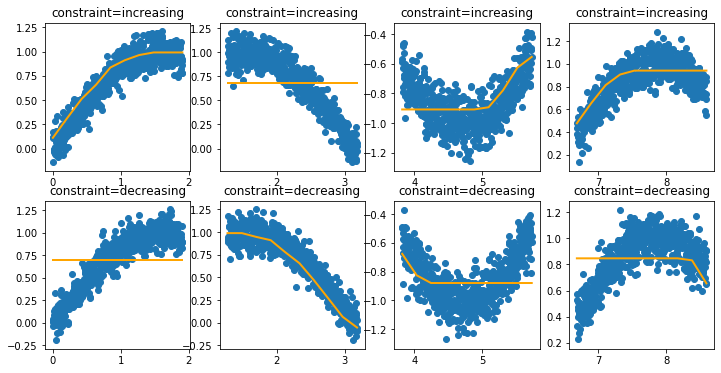

In [93]:
i = 0
plt.figure(figsize=(12, 6))
for method in ['increasing', 'decreasing']:
    for data_init in [0, 400, 1200, 2100]:
        i += 1
        xs, ys = generate_dataset(start=data_init)
        xs = xs.reshape(-1)
        plt.subplot(240 + i)
        plt.scatter(xs, ys) 
        intervals = np.quantile(xs, np.linspace(0, 1, 10))
        smoothed = _mk_monotonic_average(xs, ys, intervals=intervals, method=method, span=0.1)
        plt.plot(intervals, smoothed, color="orange", linewidth=2.0)
        plt.title(f"constraint={method}");

In [94]:
class IntervalEncoder(TransformerMixin, BaseEstimator):
    """
    The interval encoder bends features in `X` with regards to`y`.
    We take each column in X separately and smooth it towards `y` using
    the strategy that is defined in `method`.
    Note that this allows us to make certain features strictly monotonic
    in your machine learning model if you follow this with an appropriate
    model.
    :param n_chunks: the number of cuts that makes the interval
    :param method: the interpolation method used, must be in ["normal", "average"], default: "normal"
    :param span: a hyperparameter for the interpolation method, if the
    method is `normal` it resembles the width of the radial basis
    function used to weigh the points
    """

    def __init__(self, n_chunks=10, span=1, method="normal"):
        self.span = span
        self.method = method
        self.n_chunks = n_chunks

    def fit(self, X, y):
        """Fits the estimator"""
        allowed_methods = ["average", "normal", "increasing", "decreasing"]
        if self.method not in allowed_methods:
            raise ValueError(
                f"`method` must be in {allowed_methods}, got `{self.method}`"
            )
        if self.n_chunks <= 0:
            raise ValueError(f"`n_chunks` must be >= 1, received {self.n_chunks}")
        if self.span > 1.0:
            raise ValueError(
                f"Error, we expect 0 <= span <= 1, received span={self.span}"
            )
        if self.span < 0.0:
            raise ValueError(
                f"Error, we expect 0 <= span <= 1, received span={self.span}"
            )

        # these two matrices will have shape (columns, quantiles)
        # quantiles indicate where the interval split occurs
        X, y = check_X_y(X, y, estimator=self)
        self.quantiles_ = np.zeros((X.shape[1], self.n_chunks))
        # heights indicate what heights these intervals will have
        self.heights_ = np.zeros((X.shape[1], self.n_chunks))
        self.num_cols_ = X.shape[1]
        
        average_func = _mk_average if method in ["average", "normal"] else _mk_monotonic_average

        for col in range(X.shape[1]):
            self.quantiles_[col, :] = np.quantile(
                X[:, col], q=np.linspace(0, 1, self.n_chunks)
            )
            self.heights_[col, :] = average_func(
                X[:, col], y, self.quantiles_[col, :], span=self.span, method=self.method
            )
        return self

    def transform(self, X):
        """
        Transform each column such that it is bends smoothly towards y.
        """
        check_is_fitted(self, ["quantiles_", "heights_", "num_cols_"])
        X = check_array(X, estimator=self)
        if X.shape[1] != self.num_cols_:
            raise ValueError(
                f"fitted on {self.num_cols_} features but received {X.shape[1]}"
            )
        transformed = np.zeros(X.shape)
        for col in range(transformed.shape[1]):
            transformed[:, col] = np.interp(
                X[:, col], self.quantiles_[col, :], self.heights_[col, :]
            )
        return transformed

(1, 40)
(1, 40)
(1, 40)
(1, 40)
(1, 40)
(1, 40)
(1, 40)
(1, 40)


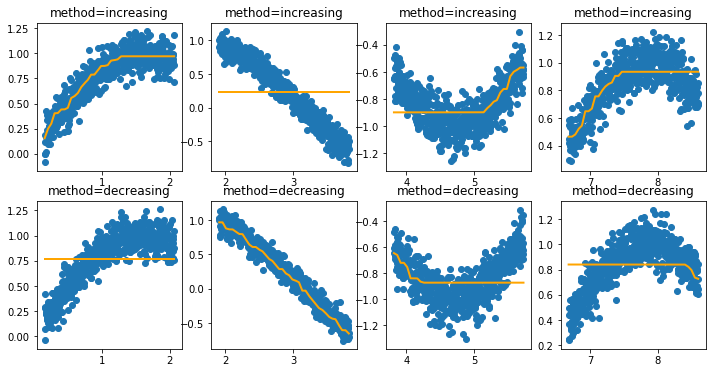

In [101]:
import cvxpy as cp
import numpy as np

i = 0
plt.figure(figsize=(12, 6))
for method in ['increasing', 'decreasing']:
    for data_init in [50, 600, 1200, 2100]:
        i += 1
        X, y = generate_dataset(start=data_init)
        encoder = IntervalEncoder(n_chunks = 40, method=method, span=0.2)
        plt.subplot(240 + i)
        plt.title(f"method={method}")
        plt.scatter(X.reshape(-1), y);
        plt.plot(X.reshape(-1), encoder.fit_transform(X, y), color='orange', linewidth=2.0);